In [1]:
import os, random, shutil
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet169
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import mixed_precision

# =====================================================
# 1. Enable Mixed Precision + Reproducibility
# =====================================================
mixed_precision.set_global_policy("mixed_float16")
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)

# =====================================================
# 2. Dataset Paths
# =====================================================
TRAIN_PATH = "archive/brisc2025/classification_task/train"
TEST_PATH  = "archive/brisc2025/classification_task/test"
VAL_PATH   = "archive/brisc2025/classification_task/val"

# =====================================================
# 3. Auto-split validation set once (15%)
# =====================================================
if not os.path.exists(VAL_PATH):
    os.makedirs(VAL_PATH)
    for cls in os.listdir(TRAIN_PATH):
        train_cls = f"{TRAIN_PATH}/{cls}"
        val_cls   = f"{VAL_PATH}/{cls}"
        os.makedirs(val_cls, exist_ok=True)

        files = os.listdir(train_cls)
        random.shuffle(files)
        val_count = int(len(files) * 0.15)

        for f in files[:val_count]:
            shutil.move(f"{train_cls}/{f}", f"{val_cls}/{f}")


# =====================================================
# 4. Data Loaders — *Shuffle ONLY Train*
# =====================================================
train_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=30,
    width_shift_range=0.20,
    height_shift_range=0.20,
    zoom_range=0.25,
    brightness_range=[0.6, 1.4],
    horizontal_flip=True,
    vertical_flip=True
).flow_from_directory(
    TRAIN_PATH, target_size=(256,256), batch_size=32,
    class_mode='categorical', shuffle=True, seed=42
)

val_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input
).flow_from_directory(
    VAL_PATH, target_size=(256,256), batch_size=32,
    class_mode='categorical', shuffle=False  
)


# =====================================================
# 5. Model — DenseNet169
# =====================================================
base = DenseNet169(weights="imagenet", include_top=False, input_shape=(256,256,3))
for layer in base.layers:
    layer.trainable = False   # Stage-1

x = layers.GlobalAveragePooling2D()(base.output)
x = layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
x = layers.Dropout(0.45)(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.35)(x)
out = layers.Dense(4, activation="softmax", dtype="float32")(x)

model = tf.keras.Model(base.input, out)


# =====================================================
# 6. Stage-1 Training (Frozen Layers)
# =====================================================
model.compile(
    optimizer=AdamW(3e-4, weight_decay=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

history1 = model.fit(
    train_gen, validation_data=val_gen, epochs=18,
    callbacks=[
        EarlyStopping(monitor="val_auc", mode="max", patience=4, restore_best_weights=True),
        ReduceLROnPlateau(monitor="val_auc", mode="max", factor=0.4, patience=2)
    ]
)


# =====================================================
# 7. Stage-2 Fine-tuning (Unfreeze deeper layers)
# =====================================================
for layer in base.layers[-120:]:
    layer.trainable = True

model.compile(
    optimizer=AdamW(1e-5, weight_decay=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

history2 = model.fit(
    train_gen, validation_data=val_gen, epochs=25,
    callbacks=[
        EarlyStopping(monitor="val_auc", mode="max", patience=6, restore_best_weights=True),
        ReduceLROnPlateau(monitor="val_auc", mode="max", factor=0.4, patience=3)
    ]
)


# =====================================================
# 8. Save Final Model
# =====================================================
model.save("DenseNet169_BRISC256_Final.h5")
print("\n Model Saved Successfully as: DenseNet169_BRISC256_Final.h5\n")


ModuleNotFoundError: No module named 'tensorflow'

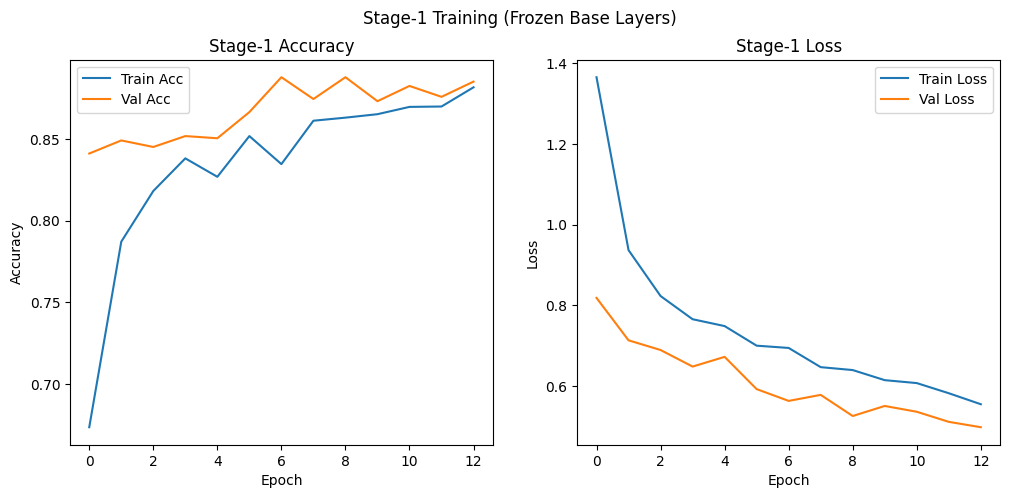

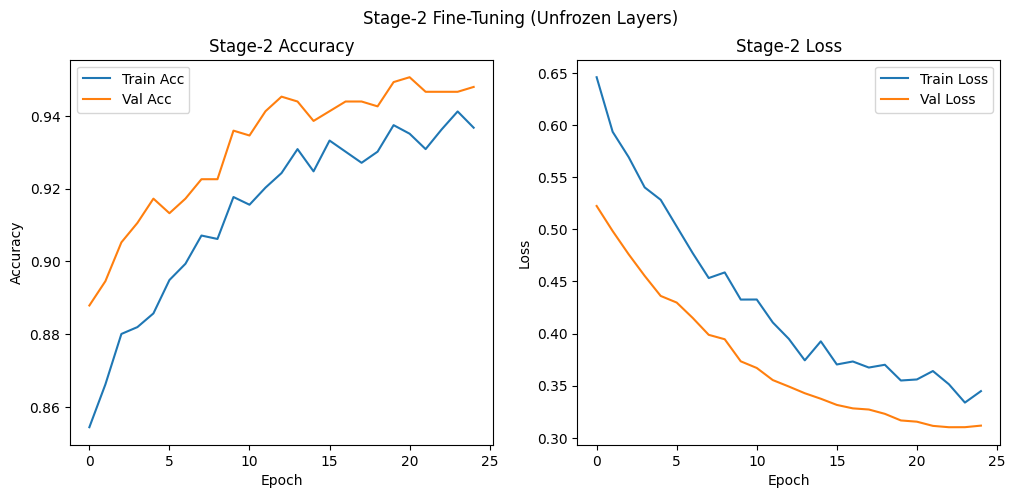

In [25]:
import matplotlib.pyplot as plt

# -------- Stage-1 Plot (history1) --------
plt.figure(figsize=(12,5))
plt.suptitle("Stage-1 Training (Frozen Base Layers)")

# Accuracy
plt.subplot(1,2,1)
plt.plot(history1.history['accuracy'], label='Train Acc')
plt.plot(history1.history['val_accuracy'], label='Val Acc')
plt.title("Stage-1 Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history1.history['loss'], label='Train Loss')
plt.plot(history1.history['val_loss'], label='Val Loss')
plt.title("Stage-1 Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()


# -------- Stage-2 Plot (history2) --------
plt.figure(figsize=(12,5))
plt.suptitle("Stage-2 Fine-Tuning (Unfrozen Layers)")

# Accuracy
plt.subplot(1,2,1)
plt.plot(history2.history['accuracy'], label='Train Acc')
plt.plot(history2.history['val_accuracy'], label='Val Acc')
plt.title("Stage-2 Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history2.history['loss'], label='Train Loss')
plt.plot(history2.history['val_loss'], label='Val Loss')
plt.title("Stage-2 Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()


24/24 ━━━━━━━━━━━━━━━━━━━━ 20s 455ms/step

Classification Report:

              precision    recall  f1-score   support

      glioma       0.90      0.94      0.92       172
  meningioma       0.93      0.89      0.91       199
    no_tumor       0.99      0.99      0.99       160
   pituitary       0.96      0.98      0.97       218

    accuracy                           0.95       749
   macro avg       0.95      0.95      0.95       749
weighted avg       0.95      0.95      0.95       749



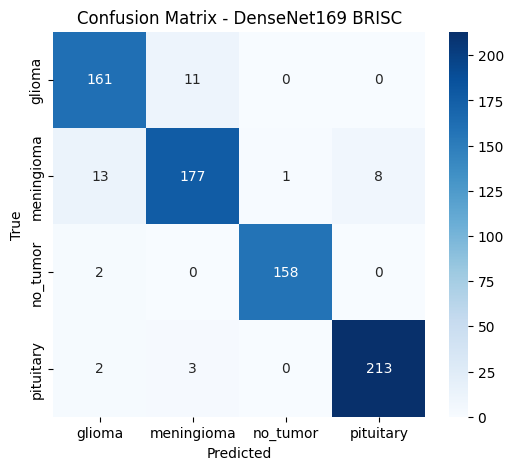

In [26]:
import numpy as np
val_gen.reset()  

y_pred_probs = model.predict(val_gen, verbose=1)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = val_gen.classes

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns; import matplotlib.pyplot as plt

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=list(val_gen.class_indices.keys())))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=val_gen.class_indices.keys(), yticklabels=val_gen.class_indices.keys())
plt.title("Confusion Matrix - DenseNet169 BRISC")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.show()

In [27]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

print(f"\nAccuracy  : {accuracy_score(y_true,y_pred)*100:.2f}%")
print(f"Precision : {precision_score(y_true,y_pred,average='weighted')*100:.2f}%")
print(f"Recall    : {recall_score(y_true,y_pred,average='weighted')*100:.2f}%")
print(f"F1-score  : {f1_score(y_true,y_pred,average='weighted')*100:.2f}%")

print("\nClassification Report:\n")
print(classification_report(y_true,y_pred, target_names=list(val_gen.class_indices.keys())))



Accuracy  : 94.66%
Precision : 94.67%
Recall    : 94.66%
F1-score  : 94.65%

Classification Report:

              precision    recall  f1-score   support

      glioma       0.90      0.94      0.92       172
  meningioma       0.93      0.89      0.91       199
    no_tumor       0.99      0.99      0.99       160
   pituitary       0.96      0.98      0.97       218

    accuracy                           0.95       749
   macro avg       0.95      0.95      0.95       749
weighted avg       0.95      0.95      0.95       749

